In [60]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import numpy as np
import seaborn as sns; sns.set()
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Import PA Census Block Group boundaries (2010-2014)

In [65]:
PA_blocks = gpd.read_file("C:/Users/raana/OneDrive/Desktop/MOIRA/PA_Ra/tl_2010_42_bg00.shp")
PA_blocks = PA_blocks[['COUNTYFP00','BKGPIDFP00','geometry']]
# Filter to block groups within Allegheny, Beaver, Butler, Washington and Westmoreland Counties
SWPA = PA_blocks[PA_blocks.COUNTYFP00.isin(['003','007','019','125','129'])]

# Import Radon data

### This cell imports each of the Radon datasets and creates a single dataset of Radon readings by year and location. The output is a shapefile with Point georaphies representing each of the households in the dataset

In [ ]:
Ra_df = pd.read_csv("C:/Users/raana/OneDrive/Desktop/MOIRA/PA_Ra/PA_RADON_1989-1993.csv")

Ra_df = Ra_df[['UNIQUE_ID',' LATITUDE',' LONGITUDE',' TEST_YEAR',' MEASURE_VALUE',' MEASURE_UNIT']]

files = ["1994-1998","1999-2003","2004-2008","2009-2013","2014-2017"]

for item in files:
    df = pd.read_csv("C:/Users/raana/OneDrive/Desktop/MOIRA/PA_Ra/PA_RADON_"+item+".csv")
    df = df[['UNIQUE_ID',' LATITUDE',' LONGITUDE',' TEST_YEAR',' MEASURE_VALUE',' MEASURE_UNIT']]
    
    Ra_df = pd.concat([Ra_df,df], ignore_index = True)

Ra_df = Ra_df[Ra_df[' LATITUDE']!=' ']
Ra_df[' LATITUDE'], Ra_df[' LONGITUDE'] = Ra_df[' LATITUDE'].astype(float), Ra_df[' LONGITUDE'].astype(float)
 
Ra_df = Ra_df[Ra_df[' LATITUDE']!=0]
Ra_df = gpd.GeoDataFrame(Ra_df, geometry=[shapely.geometry.Point((float(Ra_df[' LONGITUDE'][i]),float(Ra_df[' LATITUDE'][i]))) for i in Ra_df.index])

#print('Rows: '+str(len(Ra_df)))
#Ra_df.head()

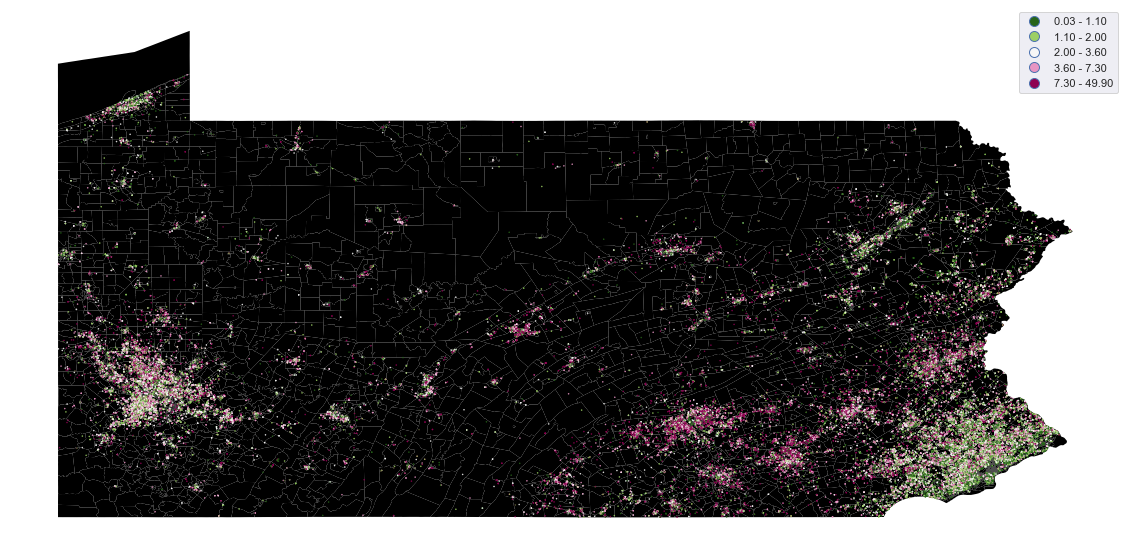

In [62]:
# PLOT RADON VALUES FOR EACH YEAR
# CHANGE YEAR AT 'Ra_df[' TEST_YEAR']== ' in line 5
ax=PA_blocks.plot(color='black',edgecolor='None', figsize=(20,15))
ax.set_axis_off()
Ra_df[Ra_df[' TEST_YEAR']==2000][Ra_df[' MEASURE_VALUE']<50].plot(column=' MEASURE_VALUE', scheme='quantiles', cmap='PiYG_r', ax=ax, legend=True, s=0.25)

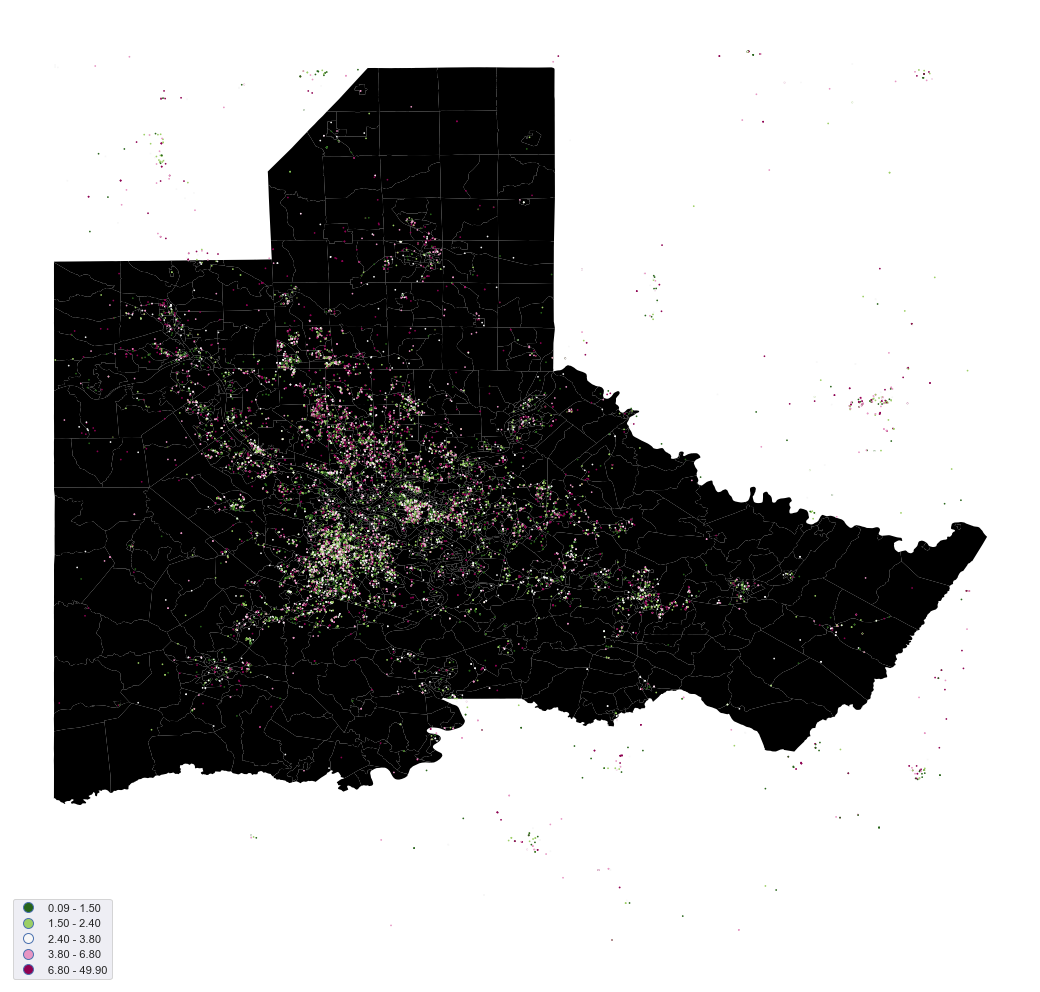

In [64]:
# PLOT RADON VALUES FOR EACH YEAR, SWPA Only
# CHANGE YEAR AT 'Ra_df[' TEST_YEAR']== ' in line 5
ax = SWPA.plot(figsize=(25,18), color='black', edgecolor='None')
ax.set_axis_off()
Ra_df[Ra_df[' TEST_YEAR']==2000][Ra_df[' MEASURE_VALUE']<50][Ra_df[' LATITUDE']<41.2][Ra_df[' LATITUDE']>38][Ra_df[' LONGITUDE']<-79].plot(column=' MEASURE_VALUE', cmap='PiYG_r', scheme='quantiles', ax=ax, legend=True, s=0.5)

In [130]:
# FILTER OUT GEOGRAPHICALLY IRRELEVANT DATA BY LAT-LON TO REDUCE FILE SIZE
SWPA_Ra = Ra_df[Ra_df[' LATITUDE']<41.2][Ra_df[' LATITUDE']>38][Ra_df[' LONGITUDE']<-79]
SWPA_Ra.head()

,UNIQUE_ID,LATITUDE,LONGITUDE,TEST_YEAR,MEASURE_VALUE,MEASURE_UNIT
13,1.840000e+11,40.4212,-79.8861,1992,0.15,pCi/L
14,1.840000e+11,40.4212,-79.8861,1992,0.15,pCi/L
15,1.840000e+11,40.4212,-79.8861,1992,0.15,pCi/L
16,1.840000e+11,40.4212,-79.8861,1992,0.16,pCi/L
17,1.840000e+11,40.4212,-79.8861,1992,0.16,pCi/L


# Aggregate Radon levels to Census block group

### This cell assigns a census block group ID to each point in the dataset, then filters out duplicate rows and creates a Point object for each observation

In [35]:
SWPA_Ra = gpd.sjoin(SWPA_Ra, SWPA, how="left", op='intersects')
SWPA_Ra = SWPA_Ra[['UNIQUE_ID', ' LATITUDE', ' LONGITUDE', ' TEST_YEAR', ' MEASURE_VALUE',' MEASURE_UNIT', 'BKGPIDFP00']].drop_duplicates()
len(SWPA_Ra)
PA_Ra['geometry'] = [PA_Ra_df['geometry'][i] for i in PA_Ra.index]
#print('With dupes: {}, Without dupes: {}'.format(len(PA_Ra_df),len(PA_Ra)))

387756

### This function filters the larger dataset by year, then blockgroup ID, collects descriptive statistics and then saves a dataset of aggregated Radon values per block group for each decade

In [ ]:
x=0
for years in [[1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998],[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008],[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]]:
    x+=1
    df = SWPA_Ra[SWPA_Ra[' TEST_YEAR'].isin(years)]
    years = pd.Series(years)
    
    filename = "C:/Users/raana/OneDrive/Desktop/MOIRA/PA_Ra/Ra_blocks2010_"+str(years.max())+".csv"
    
    med, mad, avg, std, n, p75 = [], [], [], [], [], []
    ii = 0
    for i in SWPA.index: 
        ndf = df[df.BKGPIDFP00 == SWPA.BKGPIDFP00[i]] # FOR EACH CENSUS BLOCK GROUP IN SELECTED COUNTIES (PA)
        
        # filter out outliers
        if ndf[' MEASURE_VALUE'].max() > 100:
            ndf = ndf[ndf[' MEASURE_VALUE']<100]
            
        # grab stats
        n.append(len(ndf.dropna()))
        med.append(ndf[' MEASURE_VALUE'].median()) 
        avg.append(ndf[' MEASURE_VALUE'].mean()) 
        mad.append(ndf[' MEASURE_VALUE'].mad()) 
        std.append(ndf[' MEASURE_VALUE'].std())
        p75.append(ndf[' MEASURE_VALUE'].describe()[6])
        #Print progress
        ii += 1
        print("Progress: {:.2%}".format((ii/len(SWPA)/x)),end='\r') 
        
    #swPA['Time Period'] = ['{}-{}'.format() for x in range(0,len(swPA))]
    SWPA['n'] = n
    SWPA['MEDIAN_Ra'] = med
    SWPA['75%'] = p75
    SWPA['MAD_Ra'] = mad
    SWPA['MEAN_Ra'] = avg
    SWPA['STDV_Ra'] = std
    
    pd.DataFrame(SWPA[['COUNTYFP00','BKGPIDFP00','MEDIAN_Ra','75%','MAD_Ra','MEAN_Ra','STDV_Ra','n']]).to_csv(filename)
    print('File saved: '+filename)

Measurements per County: 1989 - 1998
Allegheny: 49972
Beaver: 3202
Westmoreland: 5954
Washington: 2816
Butler: 5756
--------------------------------------------------------
Measurements per County: 1999 - 2008
Allegheny: 83071
Beaver: 7473
Westmoreland: 18885
Washington: 8985
Butler: 12300
--------------------------------------------------------
Measurements per County: 2009 - 2017
Allegheny: 97548
Beaver: 11072
Westmoreland: 22883
Washington: 13021
Butler: 15160
--------------------------------------------------------


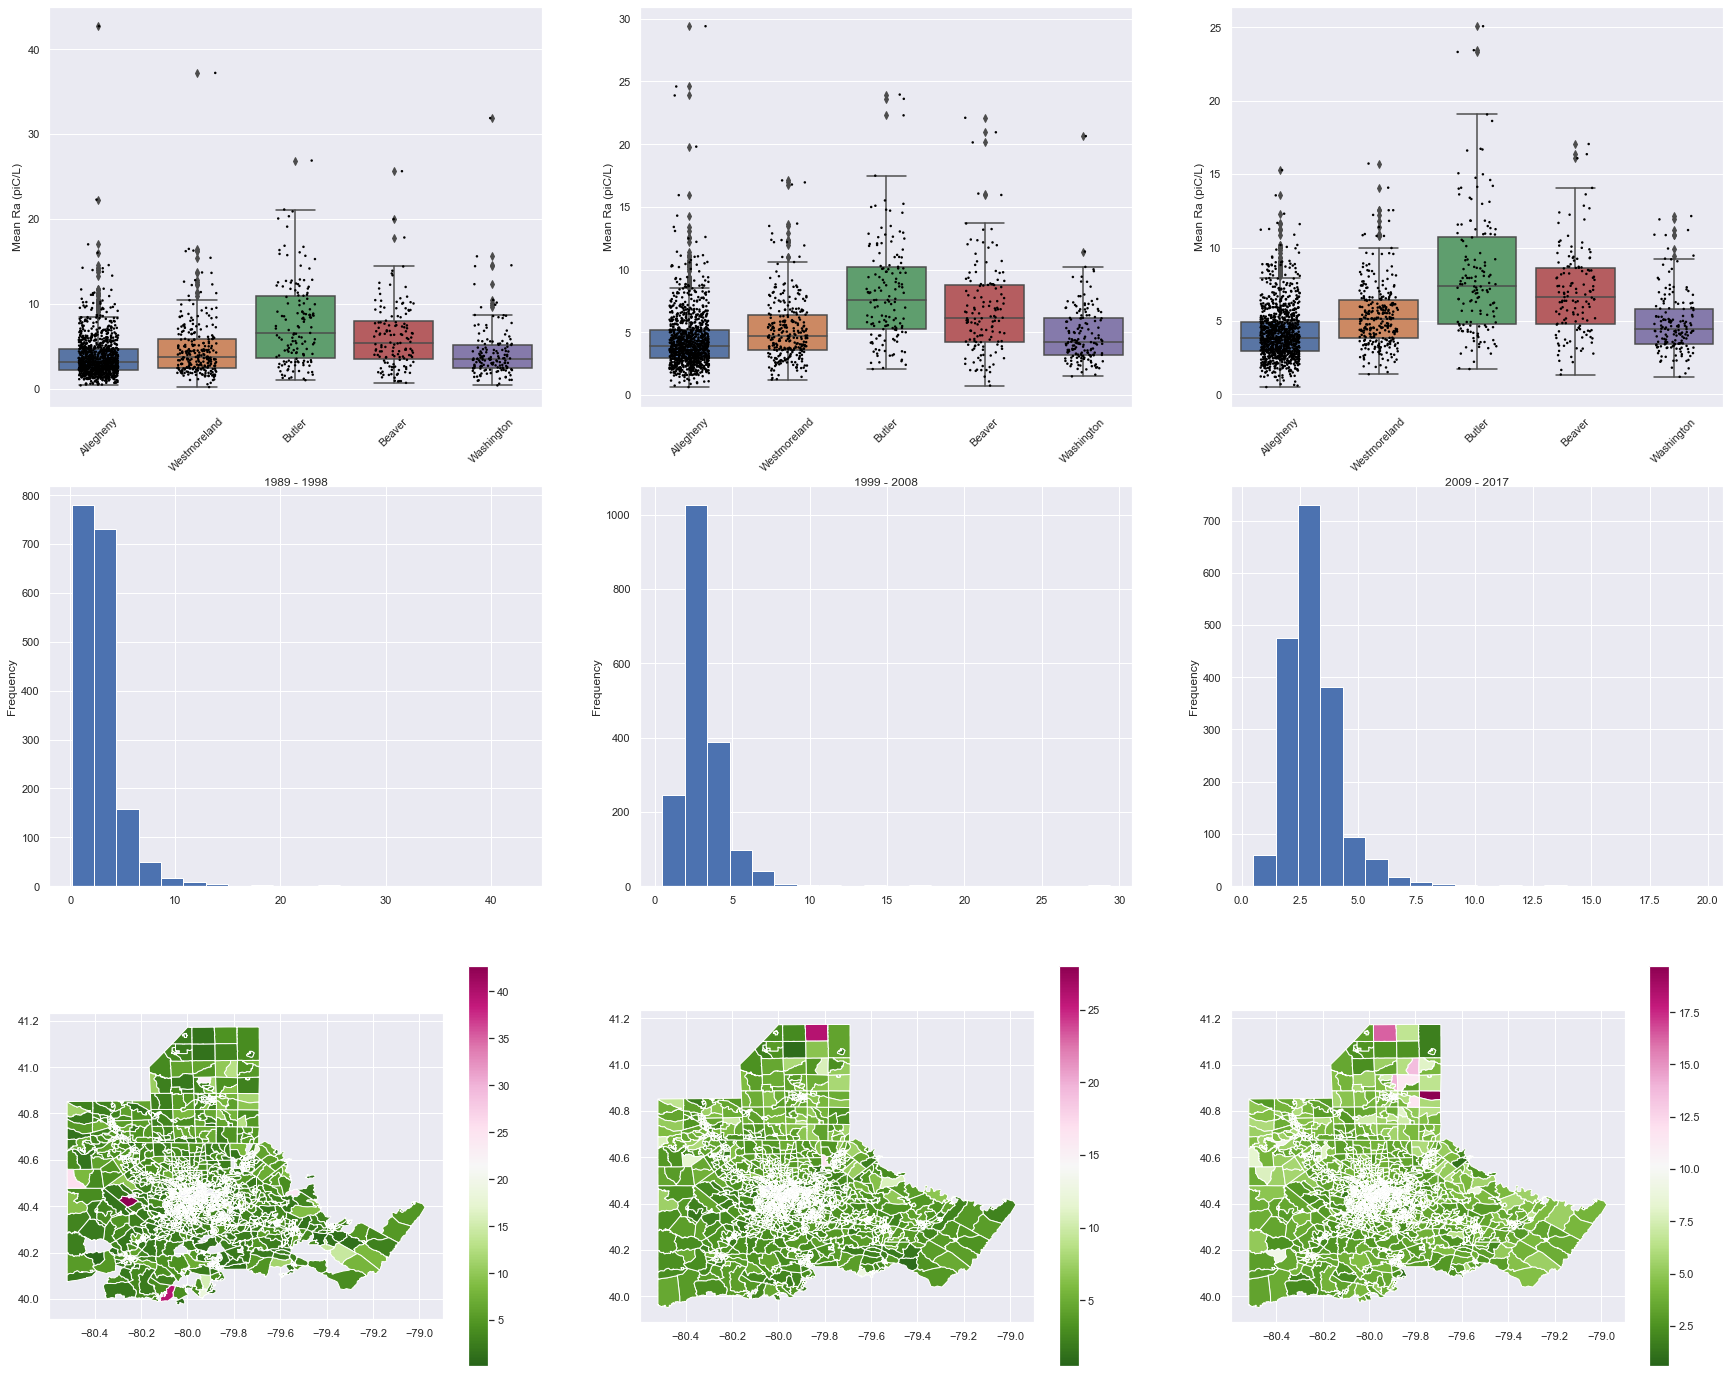

In [93]:
yr = [('1989','1998'),('1999','2008'),('2009','2017')]
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(30)
plt.rcParams.update({'font.size': 18})
for i in range(0,3):
    ax = plt.subplot(3,3,i+1)
    timePeriod = str(yr[i][0])+" - "+str(yr[i][1])
    df = pd.read_csv('C:/Users/raana/OneDrive/Desktop/MOIRA/PA_Ra/Ra_blocks2010_'+ yr[i][1] +'.csv')
    df = df.rename(columns={"MEAN_Ra": 'Mean Ra (piC/L)', "COUNTYFP00": timePeriod})
    print('Measurements per County: '+timePeriod)        
    df[timePeriod] = df[timePeriod].astype(str)
    df[[timePeriod]] = df[timePeriod].replace("3","Allegheny")
    print('Allegheny: '+str(sum(df[df[timePeriod]=='Allegheny']['n'])))
    df[[timePeriod]] = df[timePeriod].replace("7","Beaver")
    print('Beaver: '+str(sum(df[df[timePeriod]=='Beaver']['n'])))
    df[[timePeriod]] = df[timePeriod].replace("129","Westmoreland")
    print('Westmoreland: '+str(sum(df[df[timePeriod]=='Westmoreland']['n'])))
    df[[timePeriod]] = df[timePeriod].replace("125","Washington")
    print('Washington: '+str(sum(df[df[timePeriod]=='Washington']['n'])))
    df[[timePeriod]] = df[timePeriod].replace("19","Butler")
    print('Butler: '+str(sum(df[df[timePeriod]=="Butler"]['n'])))
    print('--------------------------------------------------------')
    df['BKGPIDFP00'] = df['BKGPIDFP00'].astype(str)
    df = pd.merge(df, PA_blocks[['BKGPIDFP00','geometry']], how='inner',on='BKGPIDFP00')
    df = gpd.GeoDataFrame(df)
    ax.set_xticklabels(labels =["Beaver","Butler","Allegheny","Washington","Westmoreland"], rotation = 45)
    sns.boxplot(ax=ax, x=timePeriod, y="Mean Ra (piC/L)", data=df)
    sns.stripplot(ax = ax, x=timePeriod, y="Mean Ra (piC/L)", data=df, color="black", jitter=0.2, size=2.5)
    ax = plt.subplot(3,3,i+4)
    df['MEDIAN_Ra'].plot.hist(bins=20)
    ax = plt.subplot(3,3,i+7)
    df.dropna().plot(ax=ax, column="MEDIAN_Ra", cmap="PiYG_r", legend=True)

## American Community Survey; 2010 Population by Age and Sex (5 year estimates)

### This cell calculates the estimated population 55 years or older

In [43]:
df = pd.read_csv('ACS_14_5YR_B01001_with_ann.csv', header=1)
keep = ['Estimate; Male: - 55 to 59 years',
 'Estimate; Male: - 60 and 61 years',
 'Estimate; Male: - 62 to 64 years',
 'Estimate; Male: - 65 and 66 years',
 'Estimate; Male: - 67 to 69 years',
 'Estimate; Male: - 70 to 74 years',
 'Estimate; Male: - 75 to 79 years',
 'Estimate; Male: - 80 to 84 years',
 'Estimate; Male: - 85 years and over',
 'Estimate; Female: - 55 to 59 years',
 'Estimate; Female: - 60 and 61 years',
 'Estimate; Female: - 62 to 64 years',
 'Estimate; Female: - 65 and 66 years',
 'Estimate; Female: - 67 to 69 years',
 'Estimate; Female: - 70 to 74 years',
 'Estimate; Female: - 75 to 79 years',
 'Estimate; Female: - 80 to 84 years',
 'Estimate; Female: - 85 years and over']

# Clean data, convert to float 
for i in keep:
    df[[i]] = df[i].replace('-',np.nan)
    df[i] = df[i].astype(float)
    
df['55+']=df['Estimate; Male: - 55 to 59 years']+df['Estimate; Male: - 60 and 61 years']+df['Estimate; Male: - 62 to 64 years']+df['Estimate; Male: - 65 and 66 years']+df['Estimate; Male: - 67 to 69 years']+df['Estimate; Male: - 70 to 74 years']+df['Estimate; Male: - 75 to 79 years']+df['Estimate; Male: - 80 to 84 years']+df['Estimate; Male: - 85 years and over']+df['Estimate; Female: - 55 to 59 years']+df['Estimate; Female: - 60 and 61 years']+df['Estimate; Female: - 62 to 64 years']+df['Estimate; Female: - 65 and 66 years']+df['Estimate; Female: - 67 to 69 years']+df['Estimate; Female: - 70 to 74 years']+df['Estimate; Female: - 75 to 79 years']+df['Estimate; Female: - 80 to 84 years']+df['Estimate; Female: - 85 years and over']

## Import Radon data (2010-2017) and merge with population data

In [45]:
Ra17 = pd.read_csv('C:/Users/raana/OneDrive/Desktop/MOIRA/PA_Ra/Ra_blocks2010_2017.csv')
Ra17 = Ra17.rename(columns={'BKGPIDFP00':'Id2'})
Ra17 = pd.merge(Ra17[['Id2','MEDIAN_Ra', 'MAD_Ra', '75%', 'n']], df[['Id2','55+']], on='Id2', how='left')
PA_blocks['Id2'] = PA_blocks['BKGPIDFP00'].astype(str)
Ra17['Id2'] = Ra17['Id2'].astype(str)
Ra17 = pd.merge(Ra17, PA_blocks, on='Id2', how='left')
Ra17

,Id2,MEDIAN_Ra,MAD_Ra,75%,n,55+,COUNTYFP00,BKGPIDFP00,geometry
0,420034870002,3.30,2.122449,5.600,21,374.0,003,420034870002,"POLYGON ((-79.897328 40.355551, -79.897306 40...."
1,420034870001,3.10,2.802000,4.150,30,360.0,003,420034870001,"POLYGON ((-79.89626299999999 40.351125, -79.89..."
2,420034867001,2.15,0.991420,3.175,26,478.0,003,420034867001,"POLYGON ((-79.848851 40.385003, -79.8473619999..."
3,420034867002,3.00,1.466667,4.100,3,226.0,003,420034867002,"POLYGON ((-79.852683 40.378702, -79.852283 40...."
4,420034868001,3.90,0.000000,3.900,1,233.0,003,420034868001,"POLYGON ((-79.83859199999999 40.375179, -79.83..."
5,420035236001,3.40,2.948204,6.100,46,781.0,003,420035236001,"POLYGON ((-79.82472799999999 40.465703, -79.82..."
6,420035235021,3.20,3.798623,6.250,66,463.0,003,420035235021,"POLYGON ((-79.810558 40.459828, -79.8106619999..."
7,420035235013,2.50,4.414508,4.900,101,535.0,003,420035235013,"POLYGON ((-79.82007399999999 40.471082, -79.81..."
8,420035235012,2.80,3.141494,5.000,104,417.0,003,420035235012,"POLYGON ((-79.819998 40.482894, -79.819548 40...."
9,420035235011,2.40,2.542857,3.425,84,650.0,003,420035235011,"POLYGON ((-79.808263 40.46695, -79.808984 40.4..."


## Import Lung Cancer Deaths (UPMC)

### This cell calculates the Mortality Rate per 100 and 1,000 (age 55 or older) within each Census block group, for years 2010 +

In [47]:
swPA = pd.read_csv('swPA20142017_updated.csv')
swPA = gpd.GeoDataFrame(swPA, geometry=[shapely.geometry.Point((swPA.X[i],swPA.Y[i])) for i in swPA.index])
lungs = gpd.GeoDataFrame(swPA[swPA.DxYear>2009][swPA.AgeDx>54])
n_lung, rate100, rate1000 = [], [], []
for i in Ra17.index:
    
    block = gpd.GeoDataFrame(geometry=[Ra17.geometry[i]])   
    
    temp = gpd.sjoin(lungs, block, how='inner', op='intersects')
    
    n = len(temp)
    n_lung.append(n)
    p = Ra17['55+'][i]/100
    pp = Ra17['55+'][i]/1000
    rate100.append(n/p)
    rate1000.append(n/pp)
    
    print('Progress: {:.2%}'.format(i/len(Ra17)),end='\r')

Ra17['Rate Per 100'] = rate100
Ra17['Rate Per 1000'] = rate1000    
Ra17['n_lung']=n_lung
Ra17

Ra17[['COUNTYFP00','BKGPIDFP00',
      'MEDIAN_Ra','MAD_Ra','75%','n',
      '55+',
      'n_lung','Rate Per 100','Rate Per 1000']].to_csv('Ra_lungcancer_PAblocks10_2010_2017.csv')

C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Id2,MEDIAN_Ra,MAD_Ra,75%,n,55+,COUNTYFP00,BKGPIDFP00,geometry,Rate Per 100,Rate Per 1000,n_lung
0,420034870002,3.30,2.122449,5.600,21,374.0,003,420034870002,"POLYGON ((-79.897328 40.355551, -79.897306 40....",2.139037,21.390374,8
1,420034870001,3.10,2.802000,4.150,30,360.0,003,420034870001,"POLYGON ((-79.89626299999999 40.351125, -79.89...",1.111111,11.111111,4
2,420034867001,2.15,0.991420,3.175,26,478.0,003,420034867001,"POLYGON ((-79.848851 40.385003, -79.8473619999...",1.046025,10.460251,5
3,420034867002,3.00,1.466667,4.100,3,226.0,003,420034867002,"POLYGON ((-79.852683 40.378702, -79.852283 40....",1.327434,13.274336,3
4,420034868001,3.90,0.000000,3.900,1,233.0,003,420034868001,"POLYGON ((-79.83859199999999 40.375179, -79.83...",0.858369,8.583691,2
5,420035236001,3.40,2.948204,6.100,46,781.0,003,420035236001,"POLYGON ((-79.82472799999999 40.465703, -79.82...",0.512164,5.121639,4
6,420035235021,3.20,3.798623,6.250,66,463.0,003,420035235021,"POLYGON ((-79.810558 40.459828, -79.8106619999...",0.431965,4.319654,2
7,420035235013,2.50,4.414508,4.900,101,535.0,003,420035235013,"POLYGON ((-79.82007399999999 40.471082, -79.81...",1.121495,11.214953,6
8,420035235012,2.80,3.141494,5.000,104,417.0,003,420035235012,"POLYGON ((-79.819998 40.482894, -79.819548 40....",0.479616,4.796163,2
9,420035235011,2.40,2.542857,3.425,84,650.0,003,420035235011,"POLYGON ((-79.808263 40.46695, -79.808984 40.4...",1.538462,15.384615,10


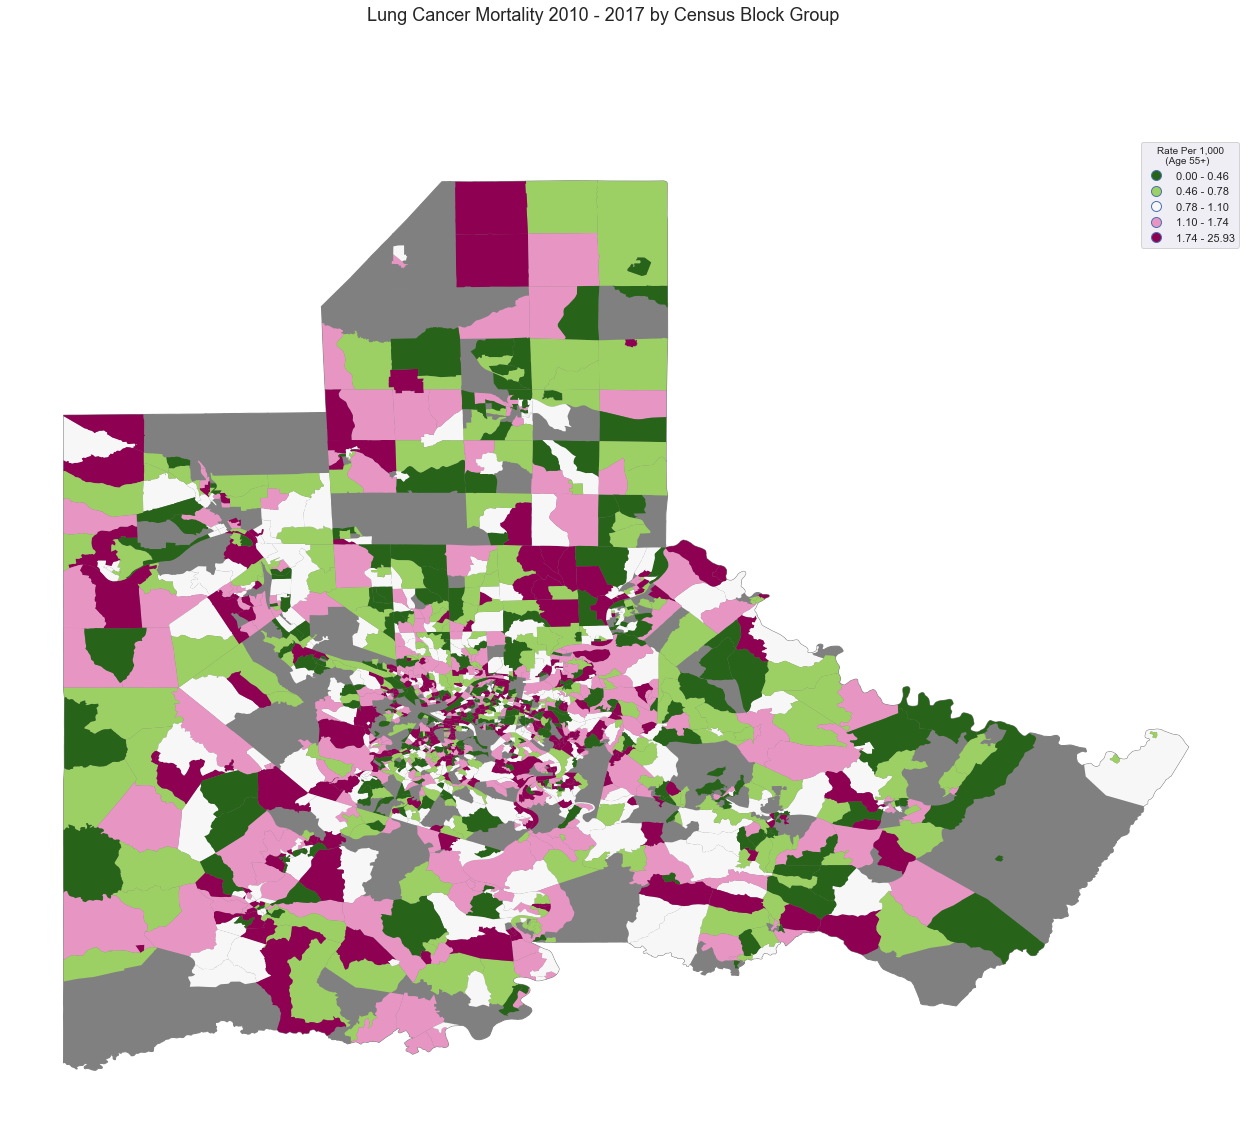

In [51]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,18))
fig.suptitle('Lung Cancer Mortality 2010 - 2017 by Census Block Group', fontsize=18)
ax=gpd.GeoDataFrame(Ra17).plot(color='Grey',edgecolor='Grey',ax=ax)
gpd.GeoDataFrame(Ra17).dropna(subset=['Rate Per 1000']).plot(column='Rate Per 100',cmap='PiYG_r',scheme='quantiles', ax=ax, 
                                                             edgecolor='None', legend=True, legend_kwds={'title':'Rate Per 1,000\n   (Age 55+)'})
ax.set_axis_off()

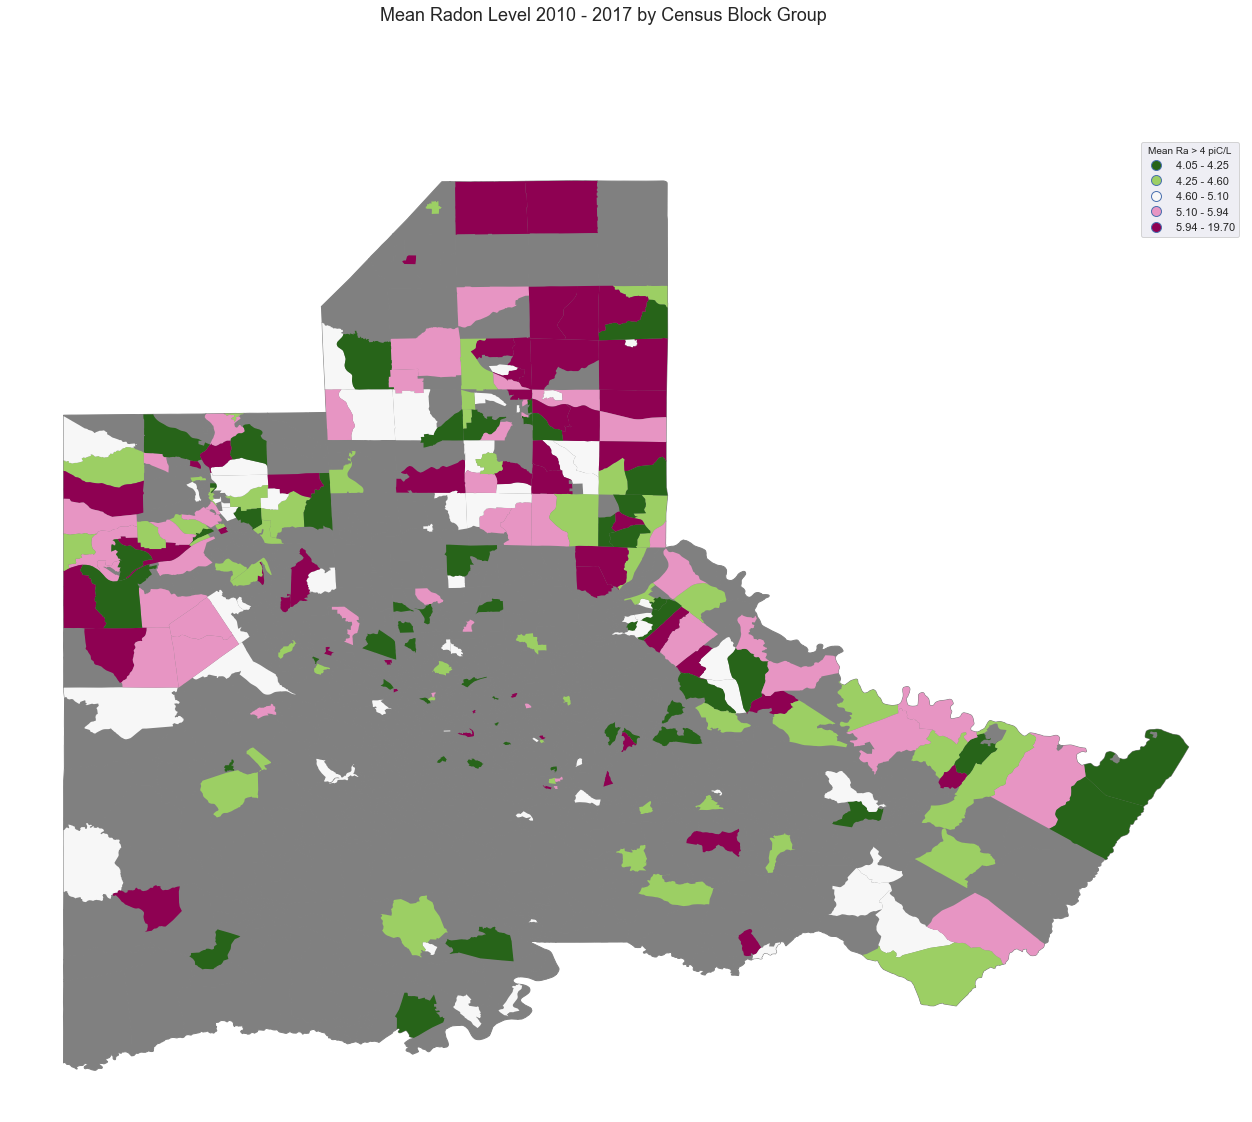

In [54]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,18))
fig.suptitle('Mean Radon Level 2010 - 2017 by Census Block Group', fontsize=18)
ax=gpd.GeoDataFrame(Ra17).plot(color='Grey',edgecolor='Grey',ax=ax)
gpd.GeoDataFrame(Ra17[Ra17.MEDIAN_Ra>4]).dropna(subset=['MEDIAN_Ra']).plot(column='MEDIAN_Ra',cmap='PiYG_r',scheme='quantiles', ax=ax, 
                                                             edgecolor='None', legend=True, legend_kwds={'title':'Mean Ra > 4 piC/L'})
ax.set_axis_off()

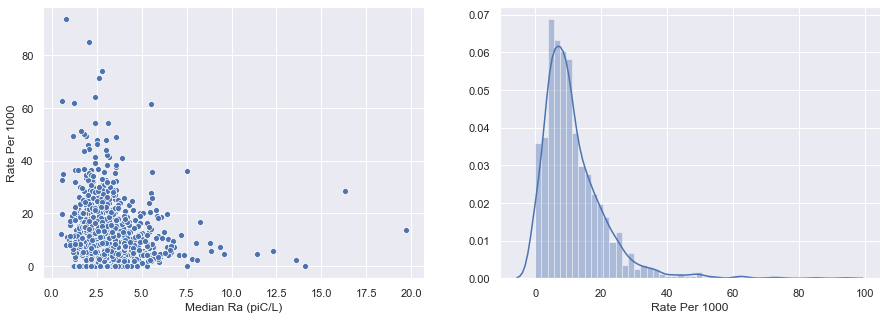

In [59]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax = sns.scatterplot(x="Median Ra (piC/L)", y="Rate Per 1000", data=Ra17[Ra17['Rate Per 1000']<250].rename(columns={'MEDIAN_Ra':'Median Ra (piC/L)'}), ax=ax)
ax1 = sns.distplot(Ra17[Ra17['Rate Per 1000']<250].dropna(subset=['Rate Per 1000'])['Rate Per 1000'], ax=ax1)

# ********************************************************************************************************************
## Import FRED population data

### This cell generates a DataFrame (id, age, sex, location) of all people age 55+  in households and group quarters from the FRED files

In [66]:
all_people = pd.DataFrame(columns=['sp_id','age','sex','latitude','longitude'])

for x in ['42003','42007','42019','42125','42129']: # grabs all the people from the different counties
    people = pd.read_csv('fred_files/'+x+'/people.txt', sep="\t")
    households = pd.read_csv('fred_files/'+x+'/households.txt', sep="\t")

    people = pd.merge(people, households[['sp_id','latitude','longitude']], left_on='sp_hh_id', right_on='sp_id', how='left')
        
    gq_people = pd.read_csv('fred_files/'+x+'/gq_people.txt', sep="\t")
    gq = pd.read_csv('fred_files/'+x+'/gq.txt', sep="\t")
    
    gq_people = pd.merge(gq_people, gq[['sp_id','latitude','longitude']], left_on='sp_gq_id', right_on='sp_id', how='left')

    all_people = pd.concat([all_people,
                            pd.concat([people[['sp_id_x','age','sex','latitude','longitude']].rename(columns={'sp_id_x':'sp_id'}), gq_people[['sp_id_x','age','sex','latitude','longitude']].rename(columns={'sp_id_x':'sp_id'})])], ignore_index=True)
                            
all_people = gpd.GeoDataFrame(all_people, geometry=[shapely.geometry.Point((all_people.longitude[i],all_people.latitude[i])) for i in all_people.index])
all_people = all_people[all_people.age>=55][['sp_id','age','sex','geometry']]
all_people

,sp_id,age,sex,geometry
184,164167509,90,F,POINT (-80.05110809999999 40.4256564)
185,164167510,90,F,POINT (-80.073086 40.3864294)
186,164167514,90,F,POINT (-80.033968 40.3938034)
187,164167515,90,F,POINT (-80.0376411 40.3856435)
188,164167516,90,F,POINT (-80.04447070000001 40.387636)
189,164167517,90,F,POINT (-80.0468407 40.3912867)
190,164167519,90,F,POINT (-80.0301407 40.3738176)
191,164167521,90,F,POINT (-80.04334799999999 40.3779947)
192,164167522,90,F,POINT (-80.04280059999999 40.3662438)
193,164167523,90,F,POINT (-80.0388301 40.3545936)


# The FRED Circle of Death
### This function creates a GeoDataFrame ('ID','age','sex','location') of lung cancer deaths as 0.5 mile radius circles, then iterates through the geometries and "kills" the closest FRED agent (with corresponding age and sex) to the center of the circle by adding its sp_id to a list death_ids.

In [122]:
#### This is just meant to print the progress in a clean way by filtering out warning output
import warnings
warnings.filterwarnings("ignore")
# Create the buffers geodataframe - 1/138 = approximately one half mile radius
buffers = gpd.GeoDataFrame({'ID':lungs.ID, 'Age':lungs.AgeDx, 'Sex':lungs.sex},geometry=[lungs.geometry[i].buffer(1/138) for i in lungs.index])
# Change 1 to M, 2 to F for Sex column
sex=[]
for i in buffers['Sex']:
    if i == 1:
        sex.append('M')
    else:
        sex.append('F')
buffers['Sex'] = sex

death_ids = []
x = 0
for i in buffers.index:
    if x == 0:
        o = 1
    else:
        o = x
    print("Progress: {:.2%}   |  Kill Rate: {:.2%}    ".format(x/len(buffers),len(death_ids)/o),end='\r')
    # Form the death circle
    death_circle = buffers.geometry[i]
    
    # Get all the people with matching age, sex
    agents = all_people[all_people.age==buffers.Age[i]][all_people.sex==buffers.Sex[i]]
    agents = agents.reset_index()
    # Get agents within the death circle
    agents['in_circle'] = agents.within(death_circle)
    agents = agents[agents.in_circle==True]
    
    # find closest agent (by  sp_id) to center of the death circle, add to death list
    agents['dist_to_center'] = [lungs.geometry[i].distance(agents.geometry[o]) for o in agents.index]
    agents.sort_values('dist_to_center', inplace=True)
    if len(agents) > 0:
        death_id = agents.sp_id[agents.index[0]]
        death_ids.append(death_id)

    x+=1

### Assign each agent a 1 if they were matched to a lung cancer death, 0 otherwise

In [131]:
dead = []
for i in all_people.sp_id:
    if i in death_ids:
        dead.append(1)
    else:
        dead.append(0)
all_people['LC_death'] = dead
all_people.to_csv("PA_Ra/FREDagents_lung.csv"); 
all_people.head()

,sp_id,age,sex,geometry,LC_death
184,164167509,90,F,POINT (-80.05110809999999 40.4256564),0
185,164167510,90,F,POINT (-80.073086 40.3864294),0
186,164167514,90,F,POINT (-80.033968 40.3938034),0
187,164167515,90,F,POINT (-80.0376411 40.3856435),0
188,164167516,90,F,POINT (-80.04447070000001 40.387636),0
